In [2]:
# load yolo model
from ultralytics import YOLO

model = YOLO("/home/nele_pauline_suffo/models/yolo11_all_detection.pt")

# load csv with video_name and frame_number
import pandas as pd
import numpy as np

df = pd.read_csv("/home/nele_pauline_suffo/outputs/proximity_sampled_frames/adult_face_samples.csv")

# delete all value in column proximity
df["proximity"] = np.nan
df

,video_name,frame_number,proximity
0,252829,31590,NaN
1,217622,210,NaN
2,114534,33870,NaN
3,152333,22860,NaN
4,205296,45180,NaN
...,...,...,...
76,243869,11790,NaN
77,264487,6780,NaN
78,119281,53070,NaN
79,139665,14190,NaN


In [5]:
# Add src directory to Python path
import sys
sys.path.append('/home/nele_pauline_suffo/projects/leuphana-IPE/src')

In [ ]:
import cv2
import os
from detection_pipeline.estimate_proximity import get_proximity

for index, row in df.iterrows():
    video_name = int(row["video_name"])
    frame_number = int(row["frame_number"])
    video_path = "/home/nele_pauline_suffo/ProcessedData/childlens_videos" + str(video_name) + ".MP4"
    print(f"Processing video {video_path}")
    # Initialize proximity as None for this frame
    proximity = None
    
    # Read frame from video
    cap = cv2.VideoCapture(video_path)

    
    # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error opening video {video_path}")
        continue
    
    # Set frame position using proper property flag
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    cap.release()
    
    if ret:  # Only process if frame was read successfully
        results = model(frame)[0]

        # Process each detection
        for box in results.boxes:
            # Extract coordinates, class and confidence
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            class_id = int(box.cls[0].cpu().numpy())
            confidence_score = float(box.conf[0].cpu().numpy())
            class_name = model.names[class_id]

            # Process faces for gaze and proximity
            if class_id in [2, 3]:  # child or adult face
                bounding_box = [x1, y1, x2, y2]
                print(f"Detected {class_name} with confidence {confidence_score} at {bounding_box}")
                proximity = get_proximity(bounding_box, class_name)
    else:
        print(f"Could not read frame {frame_number} from video {video_name}")    
    # Update dataframe with proximity (will be None if no faces were detected)
    df.loc[index, "proximity"] = proximity

Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos252829.MP4
Could not read frame 31590 from video 252829
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos217622.MP4
Could not read frame 210 from video 217622
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos114534.MP4
Could not read frame 33870 from video 114534
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos152333.MP4
Could not read frame 22860 from video 152333
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos205296.MP4
Could not read frame 45180 from video 205296
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos267118.MP4
Could not read frame 50940 from video 267118
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos210803.MP4
Could not read frame 1230 from video 210803
Processing video /home/nele_pauline_suffo/ProcessedData/childlens_videos124215.MP4
Could not read frame 387

In [12]:
df

,video_name,frame_number,proximity
0,252829,31590,NaN
1,217622,210,NaN
2,114534,33870,NaN
3,152333,22860,NaN
4,205296,45180,NaN
...,...,...,...
76,243869,11790,NaN
77,264487,6780,NaN
78,119281,53070,NaN
79,139665,14190,NaN



0: 736x1280 1 face, 9.2ms
Speed: 6.9ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Detected face with confidence 0.38718628883361816 at (1694, 126, 1766, 180)


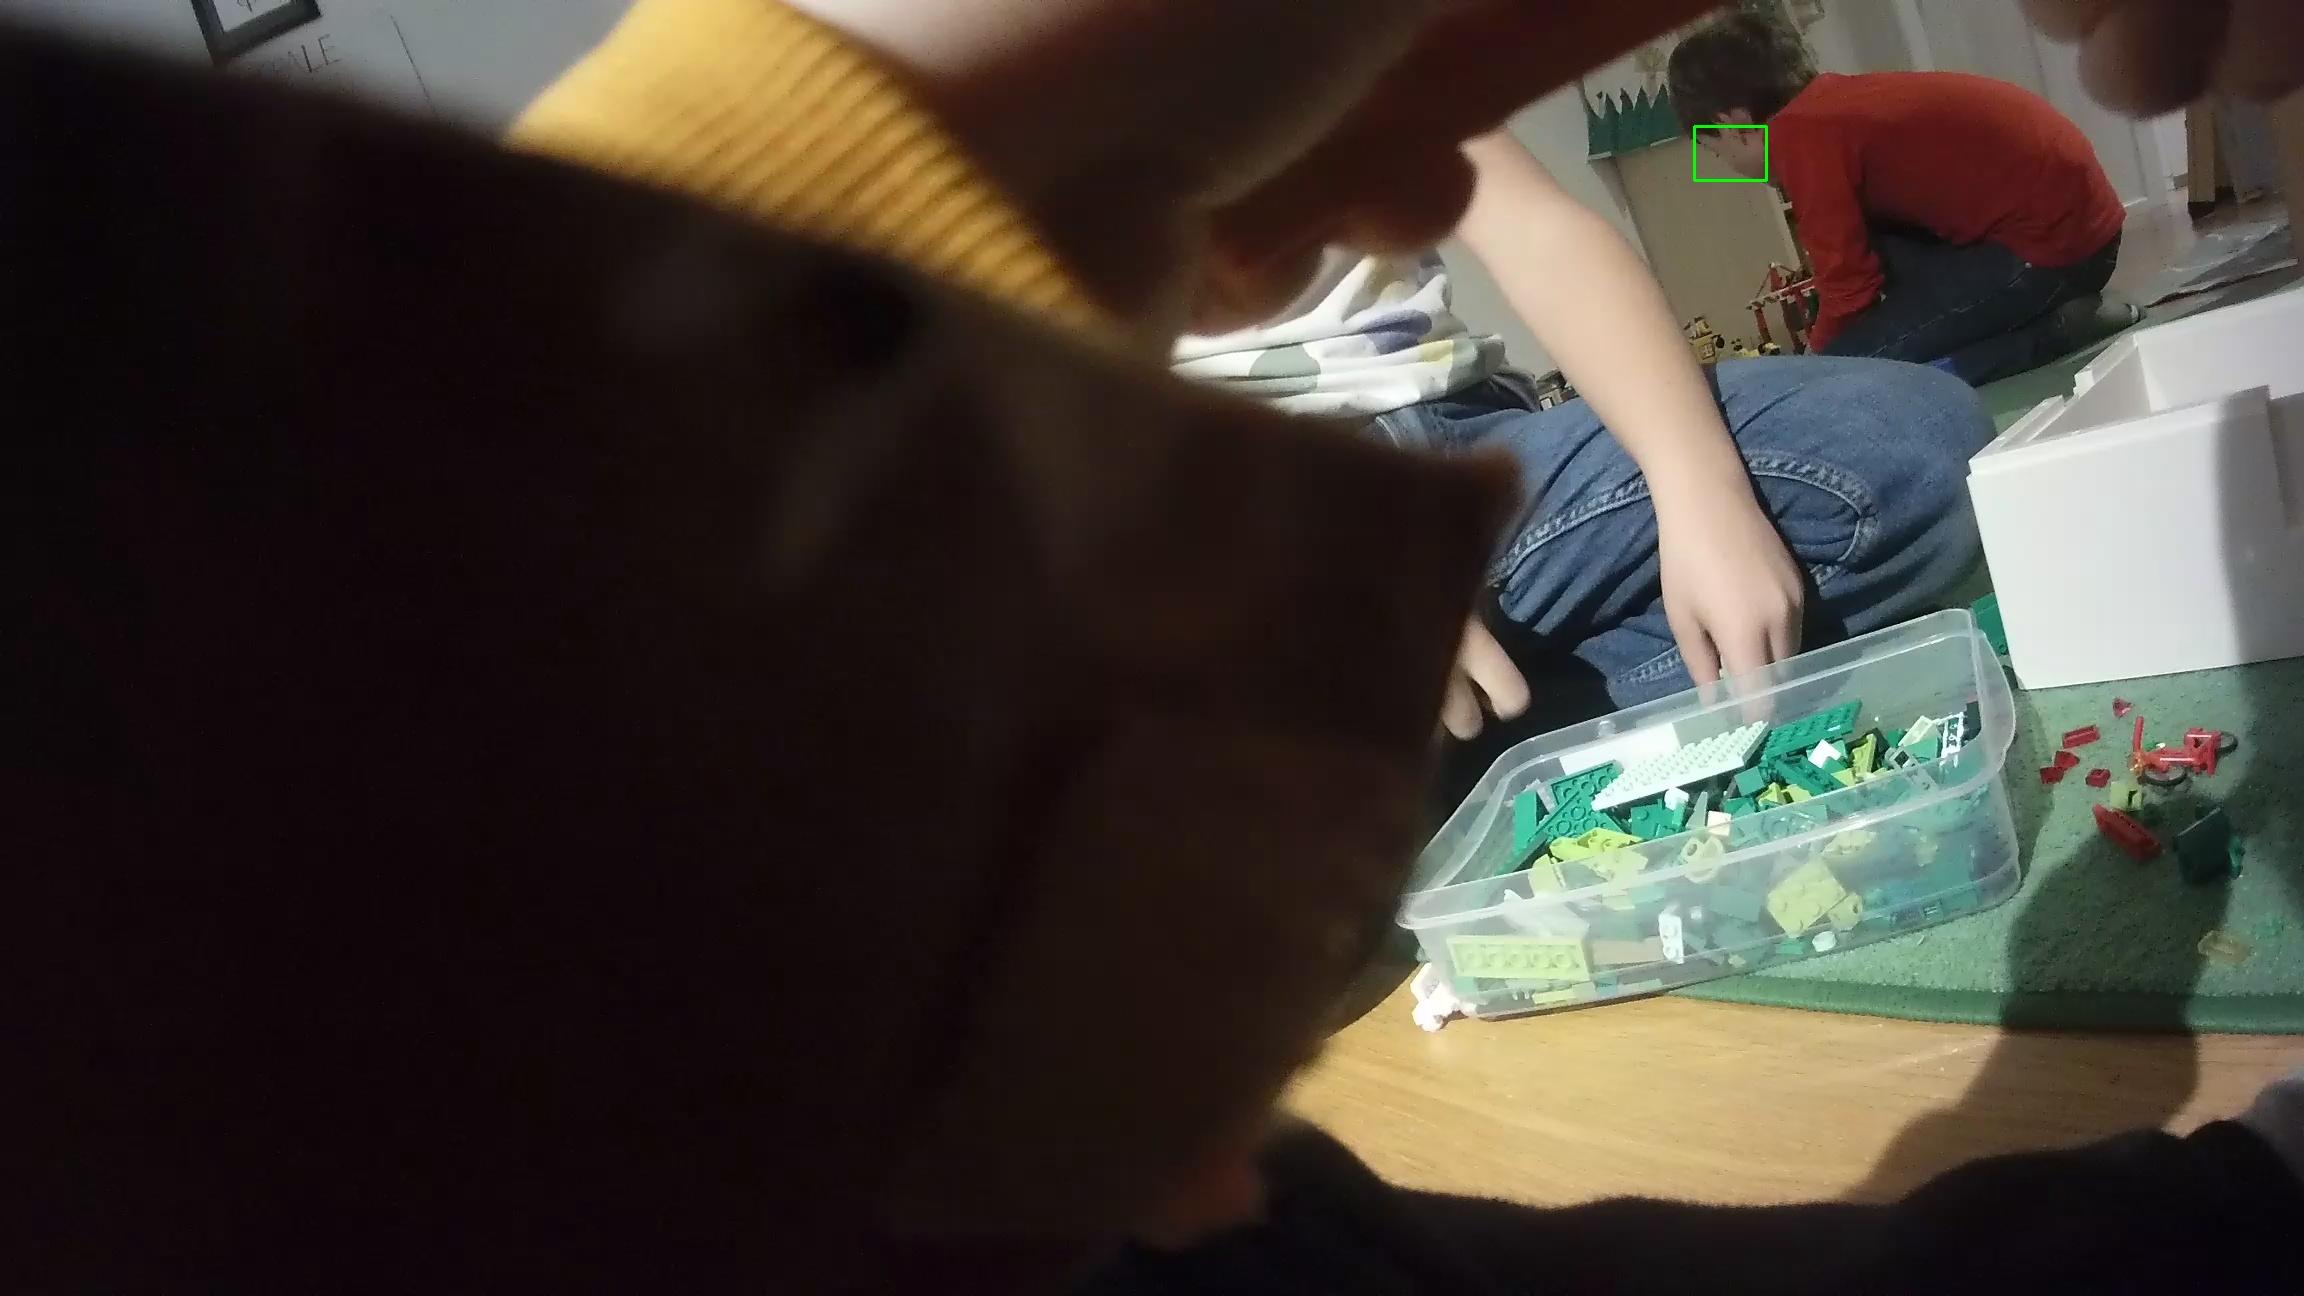

In [16]:
from ultralytics import YOLO
import cv2
from IPython.display import Image, display
import numpy as np

model = YOLO("/home/nele_pauline_suffo/models/yolo11_face_detection.pt")
#image = "/home/nele_pauline_suffo/outputs/yolo_all_detections/quantex_at_home_id255706_2018_12_21_01_002700.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id264368_2024_10_18_01/quantex_at_home_id264368_2024_10_18_01_000060.jpg"
#image = "/home/nele_pauline_suffo/outputs/yolo_all_detections/117071_024240.jpg"
#image = "/home/nele_pauline_suffo/outputs/yolo_all_detections/119281_027810.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id257609_2022_11_08_01/quantex_at_home_id257609_2022_11_08_01_000110.jpg"

#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id257608_2021_12_19_02/quantex_at_home_id257608_2021_12_19_02_003470.jpg"
#image = "/home/nele_pauline_suffo/outputs/proximity_sampled_frames/quantex_at_home_id264041_2023_05_22_07_041970.jpg"
#image = "/home/nele_pauline_suffo/outputs/proximity_sampled_frames/139665_016770.jpg"
#image = "/home/nele_pauline_suffo/outputs/proximity_sampled_frames/264487_018300.jpg"
image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id275411_2024_11_22_03/quantex_at_home_id275411_2024_11_22_03_001160.jpg"
image = cv2.imread(image)
results = model.predict(image)[0]

for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
    class_id = int(box.cls[0].cpu().numpy())
    confidence_score = float(box.conf[0].cpu().numpy())
    class_name = model.names[class_id]
    print(f"Detected {class_name} with confidence {confidence_score} at {x1, y1, x2, y2}")
    
    # display image with bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR to RGB (cv2 uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Save the image to a temporary file and display it in the notebook
cv2.imwrite('temp_output.jpg', image)
display(Image('temp_output.jpg'))


0: 384x640 1 child body parts, 24.1ms
Speed: 2.2ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Detected child body parts with confidence 0.9771695733070374 at (0, 0, 2303, 1296)


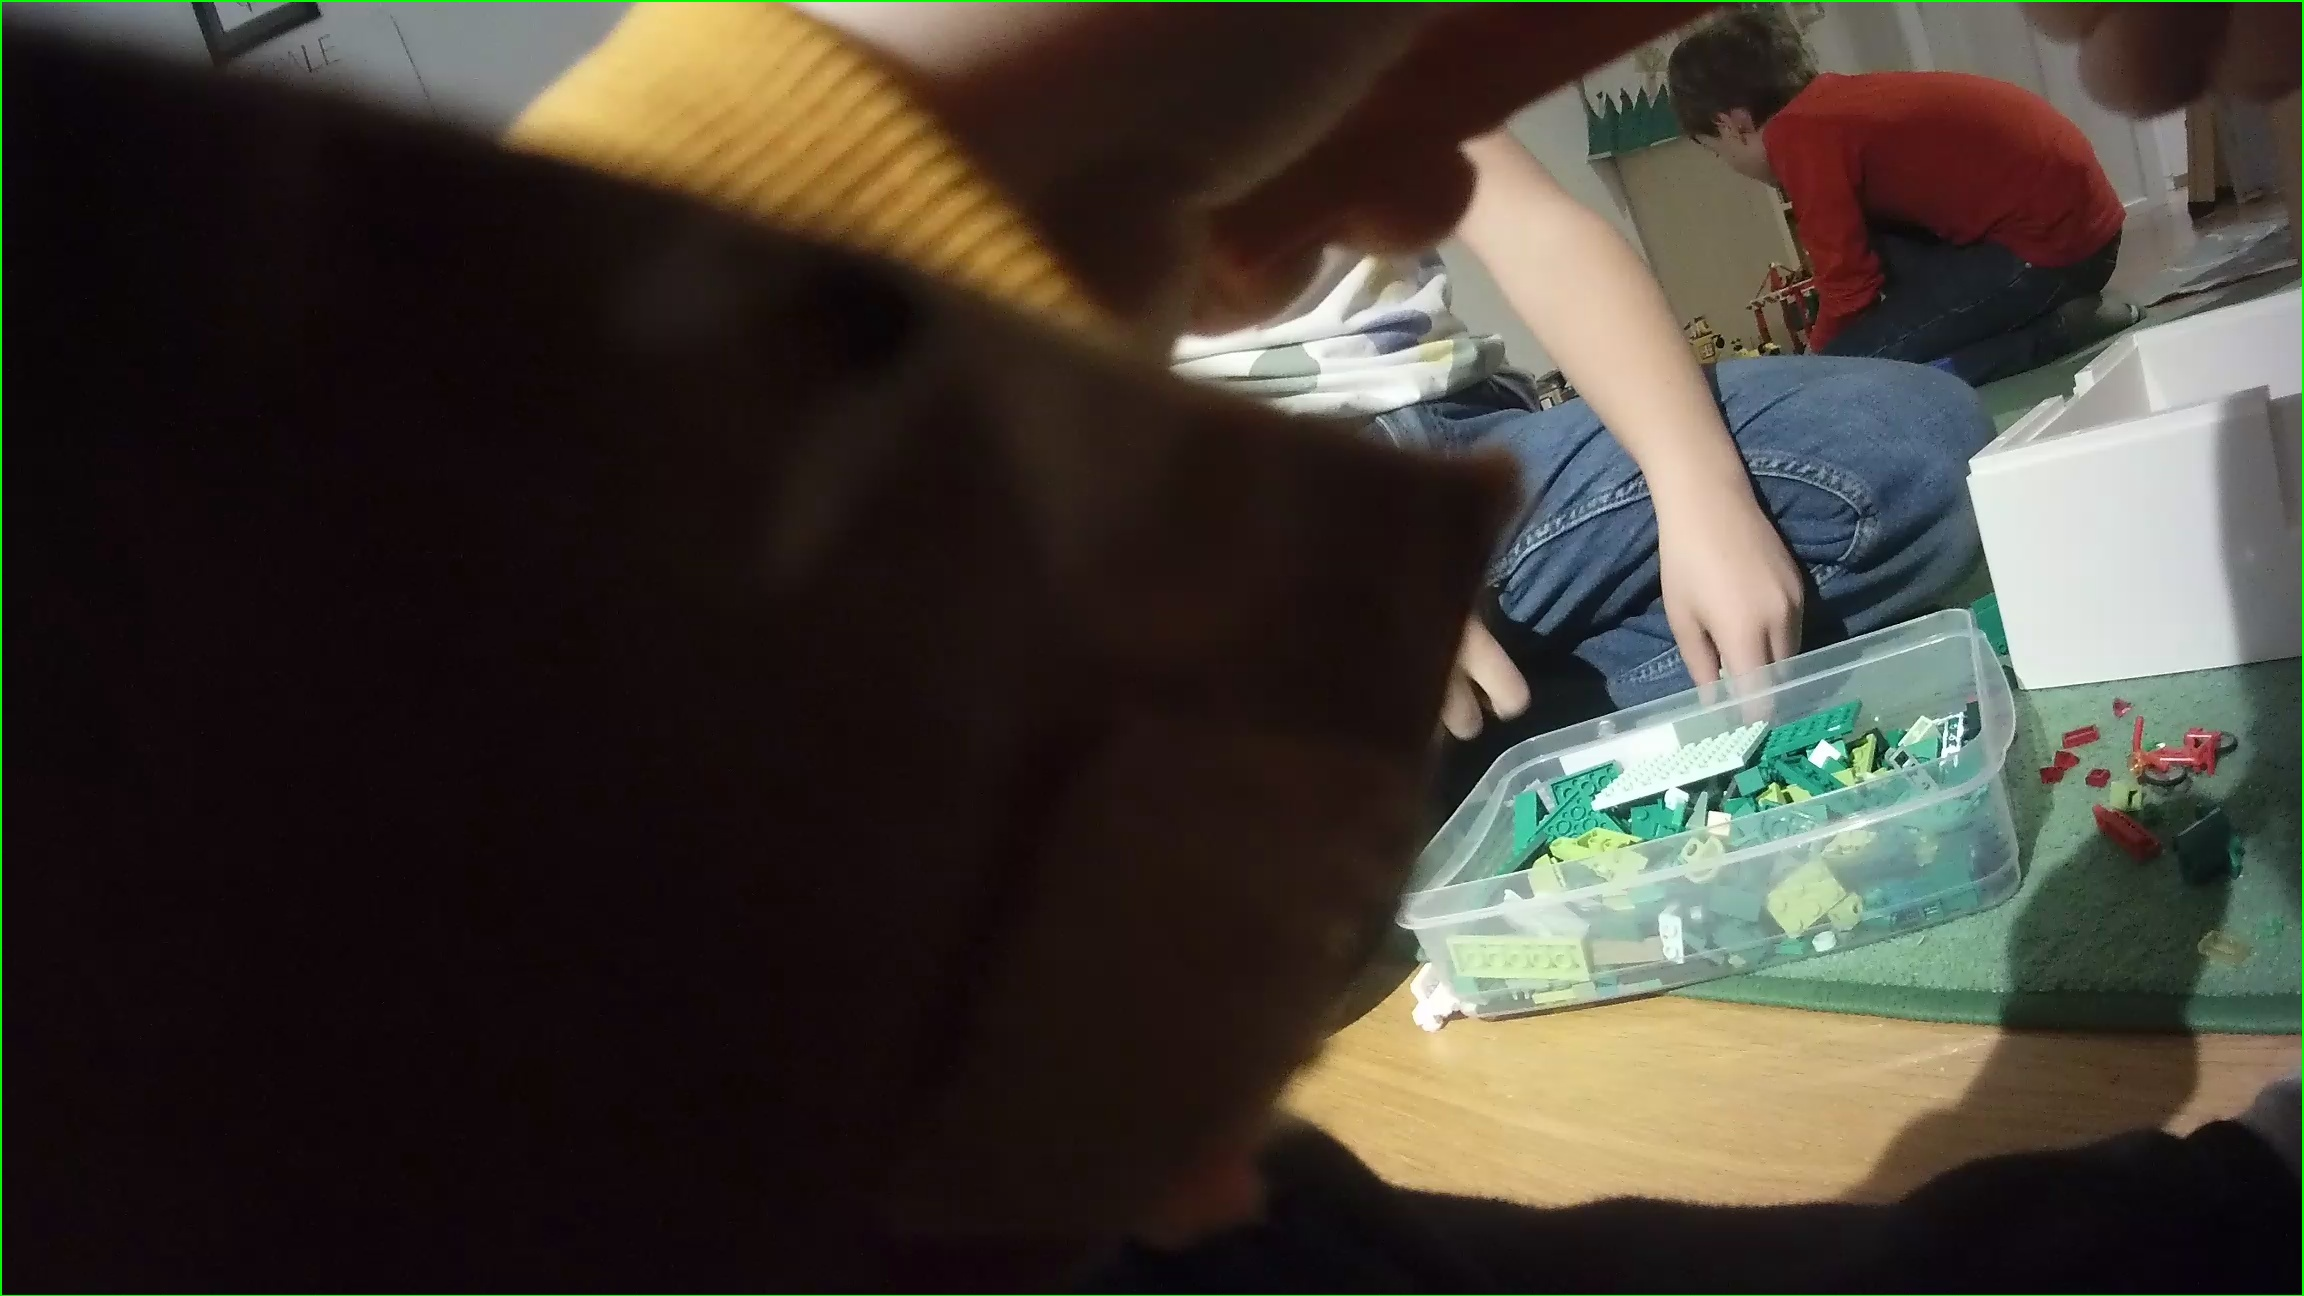

In [18]:
from ultralytics import YOLO
import cv2
from IPython.display import Image, display
import numpy as np

model = YOLO("/home/nele_pauline_suffo/models/yolo11_all_detection.pt")
#image = "/home/nele_pauline_suffo/outputs/yolo_all_detections/quantex_at_home_id255706_2018_12_21_01_002700.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id264368_2024_10_18_01/quantex_at_home_id264368_2024_10_18_01_000050.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id257608_2021_12_20_05/quantex_at_home_id257608_2021_12_20_05_015280.jpg"

#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id257608_2021_12_20_05/quantex_at_home_id257608_2021_12_20_05_005270.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id255695_2022_02_12_02/quantex_at_home_id255695_2022_02_12_02_000080.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id254922_2022_05_21_02/quantex_at_home_id254922_2022_05_21_02_010610.jpg"
#image = "/home/nele_pauline_suffo/outputs/yolo_all_detections/119281_027810.jpg"

#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id257609_2022_11_08_01/quantex_at_home_id257609_2022_11_08_01_000110.jpg"
#image = "/home/nele_pauline_suffo/outputs/proximity_sampled_frames/124215_010950.jpg"
#image = "/home/nele_pauline_suffo/outputs/proximity_sampled_frames/139665_016770.jpg"
#image = "/home/nele_pauline_suffo/outputs/proximity_sampled_frames/264487_018300.jpg"
#image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id255237_2022_05_08_04/quantex_at_home_id255237_2022_05_08_04_004900.jpg"
image = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/quantex_at_home_id275411_2024_11_22_03/quantex_at_home_id275411_2024_11_22_03_001160.jpg"
image = cv2.imread(image)
results = model.predict(image)[0]

for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
    class_id = int(box.cls[0].cpu().numpy())
    confidence_score = float(box.conf[0].cpu().numpy())
    class_name = model.names[class_id]
    print(f"Detected {class_name} with confidence {confidence_score} at {x1, y1, x2, y2}")
    
    # display image with bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR to RGB (cv2 uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Save the image to a temporary file and display it in the notebook
cv2.imwrite('temp_output.jpg', image)
display(Image('temp_output.jpg'))